# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [375]:
#Amazon Fine Food Reviews 
#Packages used 

import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
import string 
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import re


#Modules which are to be imported from sklearn.feature_extraction.text

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Modules which are to be imported from sklearn.metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

#Modules which are to be imported from nltk

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushiknaagr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [376]:
#Open an connection to the DB from python

con = sqlite3.connect('database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data=pd.read_sql_query('''
SELECT * from 
Reviews
WHERE Score!=3
'''
,con
)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
# Function to map the scores with values of 4 and 5 to Positive and 1 and 2 to negative 

def partioner(x):
    if x<3:
        return 0
    else:
        return 1
    
filter_score=filtered_data['Score']
filter_score=filter_score.map(partioner)
filtered_data['Score']=filter_score

filtered_data.shape

(525814, 10)

##  Exploratory Data Analysis

In [377]:
#Sort data in ascending order based on the values of ProductId Column

sort_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)

print(sort_data.shape)

#Remove the duplicates from the sorted data set 

sort_data=sort_data.drop_duplicates(subset=('UserId','ProfileName','Time','Text'),keep='first',inplace=False)

print(sort_data.shape)

sort_data=sort_data[sort_data['HelpfulnessNumerator']<=sort_data['HelpfulnessDenominator']]


print(sort_data['Score'].value_counts())

#Select top 100k points based on timebased sampling

sort_data=sort_data.sort_values('Time',axis=0,ascending=True)

sort_data=sort_data.head(100000)

print(sort_data.shape)

train=sort_data.iloc[0:60000]

cross_validation=sort_data.iloc[60000:80000]


cross_validation['Score'].value_counts()

test=sort_data.iloc[80000:100000]

(525814, 10)
(364173, 10)
1    307061
0     57110
Name: Score, dtype: int64
(100000, 10)


## Text Preprocessing Reviews and Summary Fields


In [378]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
Non_stopWords=set(('not','very')) # remove not and very stop words from the stopwords list
stop=stop-Non_stopWords


def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [379]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 314k sentences.
if not os.path.isfile('train.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(train['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (train['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(train['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)
        
    final_string_summary=[]
    all_positive_words_sumamry=[] # store words from +ve reviews here
    all_negative_words_summary=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(train['Summary'].values)):
        filtered_sentence_summary=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence_summary.append(s)
                        if (train['Score'].values)[i] == 1: 
                            all_positive_words_sumamry.append(s) #list of all words used to describe positive reviews
                        if(train['Score'].values)[i] == 0:
                            all_negative_words_summary.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence_summary) #final string of cleaned words
        #print("***********************************************************************")
        final_string_summary.append(str1)    

    #############---- storing the data into .sqlite file ------########################
    train['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    train['CleanedText']=train['CleanedText'].str.decode("utf-8")
    train['CleanedSummaryText']=final_string_summary #adding a column of CleanedText which displays the data after pre-processing of the review 
    train['CleanedSummaryText']=train['CleanedSummaryText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('train.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    train.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    with open('positive_words_train_summary.pkl', 'wb') as f:
        pickle.dump(all_positive_words_sumamry, f)
    with open('negitive_words_train_summary.pkl', 'wb') as f:
        pickle.dump(all_negative_words_summary, f)
    with open('positive_words_train.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words_train.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [380]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 314k sentences.
if not os.path.isfile('cross_validation.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(cross_validation['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (cross_validation['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(cross_validation['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)
    
    final_string_summary=[]
    all_positive_words_summary=[] # store words from +ve reviews here
    all_negative_words_summary=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(cross_validation['Summary'].values)):
        filtered_sentence_summary=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence_summary.append(s)
                        if (cross_validation['Score'].values)[i] == 1: 
                            all_positive_words_summary.append(s) #list of all words used to describe positive reviews
                        if(cross_validation['Score'].values)[i] == 0:
                            all_negative_words_summary.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence_summary) #final string of cleaned words
        #print("***********************************************************************")
        final_string_summary.append(str1)    

    #############---- storing the data into .sqlite file ------########################
    cross_validation['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    cross_validation['CleanedText']=cross_validation['CleanedText'].str.decode("utf-8")
    cross_validation['CleanedSummaryText']=final_string_summary #adding a column of CleanedText which displays the data after pre-processing of the review 
    cross_validation['CleanedSummaryText']=cross_validation['CleanedSummaryText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('cross_validation.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    cross_validation.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    with open('positive_words_cross_validation.pkl', 'wb') as f:
        pickle.dump(all_positive_words_summary, f)
    with open('negitive_words_cross_validation.pkl', 'wb') as f:
        pickle.dump(all_negative_words_summary, f)
    with open('positive_words_cross_validation.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words_cross_validation.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [381]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 314k sentences.
if not os.path.isfile('test.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(test['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (test['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(test['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)
    final_string_summary=[]
    all_positive_words_summary=[] # store words from +ve reviews here
    all_negative_words_summary=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(test['Summary'].values)):
        filtered_sentence_summary=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence_summary.append(s)
                        if (test['Score'].values)[i] == 1: 
                            all_positive_words_summary.append(s) #list of all words used to describe positive reviews
                        if(test['Score'].values)[i] == 0:
                            all_negative_words_summary.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence_summary) #final string of cleaned words
        #print("***********************************************************************")
        final_string_summary.append(str1)

    #############---- storing the data into .sqlite file ------########################
    test['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    test['CleanedText']=test['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    test['CleanedSummaryText']=final_string_summary #adding a column of CleanedText which displays the data after pre-processing of the review 
    test['CleanedSummaryText']=test['CleanedSummaryText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('test.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    test.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    with open('positive_words_test_summary.pkl', 'wb') as f:
        pickle.dump(all_positive_words_summary, f)
    with open('negitive_words_cross_test_summary.pkl', 'wb') as f:
        pickle.dump(all_negative_words_summary, f)
    with open('positive_words_test.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words_cross_test.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

# Featurization

### BAG OF WORDS  for Summary Text

In [382]:
if os.path.isfile('train.sqlite'):
    conn = sqlite3.connect('train.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [383]:
#BoW on training Summary dataset
count_vect_sum = CountVectorizer() #in scikit-learn
final_counts_sum = count_vect_sum.fit_transform(final['CleanedSummaryText'].values)
X_train_sum=final_counts_sum
X_train_sum=normalize(X_train_sum, axis=1, norm='max')
print("the type of count vectorizer ",type(X_train_sum))
print("the shape of out text BOW vectorizer ",X_train_sum.get_shape())
print("the number of unique words ", X_train_sum.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 9357)
the number of unique words  9357


In [384]:
if os.path.isfile('cross_validation.sqlite'):
    conn = sqlite3.connect('cross_validation.sqlite')
    final_cross_validation = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [385]:
#Bow on CV Summary dataset
final_counts_cross_validation_sum = count_vect_sum.transform(final_cross_validation['CleanedSummaryText'].values)
X_cv_sum=final_counts_cross_validation_sum
X_cv_sum=normalize(X_cv_sum, axis=1, norm='max')
print("the type of count vectorizer ",type(X_cv_sum))
print("the shape of out text BOW vectorizer ",X_cv_sum.get_shape())
print("the number of unique words ", X_cv_sum.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 9357)
the number of unique words  9357


In [386]:
if os.path.isfile('test.sqlite'):
    conn = sqlite3.connect('test.sqlite')
    test = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [387]:
#Bow on Test Summary dataset
test_count_sum = count_vect_sum.transform(test['CleanedSummaryText'].values)
X_test_sum=test_count_sum
X_test_sum=normalize(X_test_sum, axis=1, norm='max')
print("the type of count vectorizer ",type(X_test_sum))
print("the shape of out text BOW vectorizer ",X_test_sum.get_shape())
print("the number of unique words ", X_test_sum.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 9357)
the number of unique words  9357


### BAG OF WORDS for Review Text

In [388]:
if os.path.isfile('train.sqlite'):
    conn = sqlite3.connect('train.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [389]:
#BoW on training dataset
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
X_train=final_counts
X_train=normalize(X_train, axis=1, norm='max')
train_label=final['Score'].values
print("the type of count vectorizer ",type(X_train))
print("the shape of out text BOW vectorizer ",X_train.get_shape())
X_train=hstack((X_train, X_train_sum))
X_train =csr_matrix(X_train)
print("the type of count vectorizer ",type(X_train))
print("the shape of out text BOW vectorizer ",X_train.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 29134)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 38491)


In [390]:
if os.path.isfile('cross_validation.sqlite'):
    conn = sqlite3.connect('cross_validation.sqlite')
    final_cross_validation = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [391]:
#Bow on CV dataset
final_counts_cross_validation = count_vect.transform(final_cross_validation['CleanedText'].values)
X_cv=final_counts_cross_validation
X_cv=normalize(X_cv, axis=1, norm='max')
cv_label=final_cross_validation['Score'].values
print("the type of count vectorizer ",type(X_cv))
print("the shape of out text BOW vectorizer ",X_cv.get_shape())
X_cv=hstack((X_cv, X_cv_sum))
X_cv =csr_matrix(X_cv)
print("the type of count vectorizer ",type(X_cv))
print("the shape of out text BOW vectorizer ",X_cv.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 29134)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 38491)


In [392]:
if os.path.isfile('test.sqlite'):
    conn = sqlite3.connect('test.sqlite')
    test = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [393]:
#Bow on Test dataset
test_count = count_vect.transform(test['CleanedText'].values)
X_test=test_count
X_test=normalize(X_test, axis=1, norm='max')
test_label=test['Score'].values
print("the type of count vectorizer ",type(test_count))
print("the shape of out text BOW vectorizer ",test_count.get_shape())
X_test=hstack((X_test, X_test_sum))
X_test =csr_matrix(X_test)
print("the type of count vectorizer ",type(X_test))
print("the shape of out text BOW vectorizer ",X_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 29134)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 38491)


## Applying Logistic Regression Classifier on BOW

In [394]:
#import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

l=[10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

#Store Auc value for  train 
roc_val_cv_l1 = np.empty(len(l))

roc_val_train_l1 = np.empty(len(l))

#Store Auc value for  train 
roc_val_cv_l2 = np.empty(len(l))

roc_val_train_l2 = np.empty(len(l))


for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for Train data
    y_pred_train_l1 = []
    y_pred_proba_train_l1=[]
    #Store the predicted class labels for Train data
    y_pred_train_l2 = []
    y_pred_proba_train_l2=[]
    
    #Fit the model
    model_l1.fit(X_train, train_label)
    #Fit the model
    model_l2.fit(X_train, train_label)
    
    #Predict the Class label in Train data
    y_pred_train_l1=model_l1.predict(X_train)
    #Predict the Class label in Train data
    y_pred_train_l2=model_l2.predict(X_train)
    
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l1 = model_l1.predict_proba(X_train)[:,1]

    roc_val_train_l1[i] = roc_auc_score(train_label,y_pred_proba_train_l1)
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l2 = model_l2.predict_proba(X_train)[:,1]

    roc_val_train_l2[i] = roc_auc_score(train_label,y_pred_proba_train_l2)

In [395]:
#Performing Hyper parameter tuning for finding the best Lambda using simple cross validation.

for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for CV
    y_pred_cv_l1 = []
    y_pred_proba_cv_l1=[]
    y_pred_cv_l2 = []
    y_pred_proba_cv_l2=[]
    
    #Fit the model
    model_l1.fit(X_train, train_label)
    model_l2.fit(X_train, train_label)
    
    #Predict the Class label in CV data
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l1.predict(X_cv[d:d+2000]))
        
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l2.predict(X_cv[d:d+2000]))
        
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l1 = model_l1.predict_proba(X_cv)[:,1]
    
    roc_val_cv_l1[i] = roc_auc_score(cv_label,y_pred_proba_cv_l1)
    
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l2 = model_l2.predict_proba(X_cv)[:,1]
    
    roc_val_cv_l2[i] = roc_auc_score(cv_label,y_pred_proba_cv_l2)

In [396]:
l1_log=[np.log(i) for i in l]

l2_log=[np.log(i) for i in l]

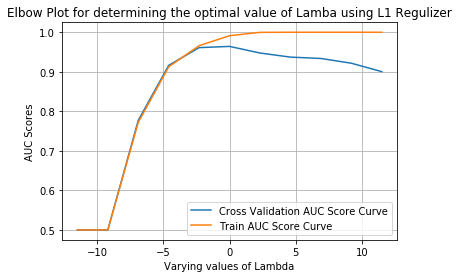

In [397]:
#Elbow Plot for determining the optimal value of Lambda using L1 regulizer
plt.title('Elbow Plot for determining the optimal value of Lamba using L1 Regulizer')
plt.plot(l1_log, roc_val_cv_l1, label='Cross Validation AUC Score Curve')
plt.plot(l1_log, roc_val_train_l1, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

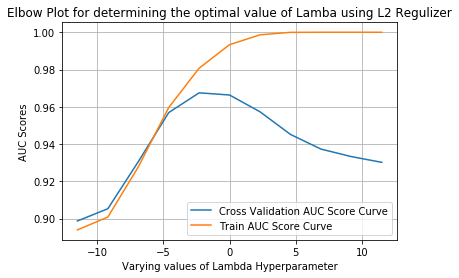

In [398]:
#Elbow Plot for determining the optimal value of Lambda using L2 regulizer
plt.title('Elbow Plot for determining the optimal value of Lamba using L2 Regulizer')
plt.plot(l2_log, roc_val_cv_l2, label='Cross Validation AUC Score Curve')
plt.plot(l2_log, roc_val_train_l2, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda Hyperparameter')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

### Fitting the Test Data using optimal lambda and applying Logistic Regression Classifier

In [399]:
final_l1=np.exp(.1)
final_l2=np.exp(2.5)

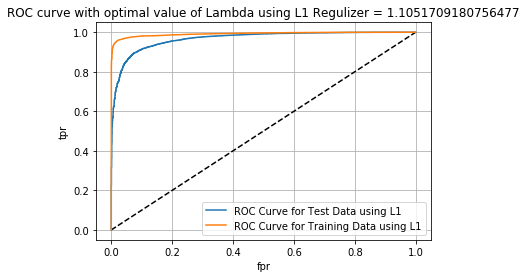

 AUC value for Test Data for Optimal Lambda using L1 Regulizer is 0.9671022116862358
 AUC value for Training Data for Optimal Lambda using L1 Regulizer 0.9918947099225965


In [400]:
# Applying Optimal Value of Lambda obtained from simple cross validation on test data for L1 and L2 regulizer

final_model_l1 = LogisticRegression(penalty='l1',C=final_l1,class_weight='balanced')
final_model_l2 = LogisticRegression(penalty='l2',C=final_l2,class_weight='balanced')

#Store the predicted class labels and prob scores for Test data
y_pred_test_l1 = []
y_pred_proba_test_l1=[]
y_pred_train_l1 = []
y_pred_proba_train_l1=[]
y_pred_test_l2 = []
y_pred_proba_test_l2=[]
y_pred_train_l2 = []
y_pred_proba_train_l2=[]
    
#Fit the model
final_model_l1.fit(X_train, train_label)
final_model_l2.fit(X_train, train_label)
    
#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l1.extend(final_model_l1.predict(X_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l1 = final_model_l1.predict_proba(X_test)[:,1]

#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l2.extend(final_model_l2.predict(X_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l2 = final_model_l2.predict_proba(X_test)[:,1]

fpr1_l1, tpr1_l1, thresholds = roc_curve(test_label,y_pred_proba_test_l1)
roc_val_test_l1 = roc_auc_score(test_label,y_pred_proba_test_l1)

fpr1_l2, tpr1_l2, thresholds = roc_curve(test_label,y_pred_proba_test_l2)
roc_val_test_l2 = roc_auc_score(test_label,y_pred_proba_test_l2)


#Predict the Class label in Train data
y_pred_train_l1=final_model_l1.predict(X_train)
y_pred_proba_train_l1=final_model_l1.predict_proba(X_train)[:,1]

#Predict the Class label in Train data
y_pred_train_l2=final_model_l2.predict(X_train)
y_pred_proba_train_l2=final_model_l2.predict_proba(X_train)[:,1]

fpr2_l1, tpr2_l1, thresholds = roc_curve(train_label,y_pred_proba_train_l1)
roc_val_train_l1 = roc_auc_score(train_label,y_pred_proba_train_l1)

fpr2_l2, tpr2_l2, thresholds = roc_curve(train_label,y_pred_proba_train_l2)
roc_val_train_l2 = roc_auc_score(train_label,y_pred_proba_train_l2)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l1,tpr1_l1, label='ROC Curve for Test Data using L1')
plt.plot(fpr2_l1,tpr2_l1, label='ROC Curve for Training Data using L1')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal value of Lambda using L1 Regulizer = {}' . format(final_l1))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L1 Regulizer is {}".format(roc_val_test_l1))
print (" AUC value for Training Data for Optimal Lambda using L1 Regulizer {}".format(roc_val_train_l1))

Classification Report using L1 Regulizer: 
             precision    recall  f1-score   support

          0       0.65      0.87      0.75      2678
          1       0.98      0.93      0.95     17322

avg / total       0.94      0.92      0.93     20000

----------------------------


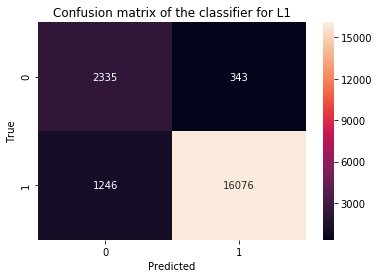

In [401]:
#Classification Report
#import classification_report
from sklearn.metrics import classification_report
print("Classification Report using L1 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l1)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
from sklearn.metrics import confusion_matrix
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l1)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier for L1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

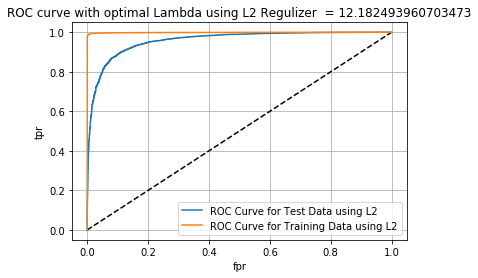

 AUC value for Test Data for Optimal Lambda using L2 Regulizer  is 0.9581805685724827
 AUC value for Training Data for Optimal Lambda using L2 Regulizer is 0.998835515066097


In [402]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l2,tpr1_l2, label='ROC Curve for Test Data using L2')
plt.plot(fpr2_l2,tpr2_l2, label='ROC Curve for Training Data using L2')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal Lambda using L2 Regulizer  = {}' . format(final_l2))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L2 Regulizer  is {}".format(roc_val_test_l2))
print (" AUC value for Training Data for Optimal Lambda using L2 Regulizer is {}".format(roc_val_train_l2))

Classification Report using L2 Regulizer: 
             precision    recall  f1-score   support

          0       0.68      0.82      0.74      2678
          1       0.97      0.94      0.96     17322

avg / total       0.93      0.92      0.93     20000

----------------------------


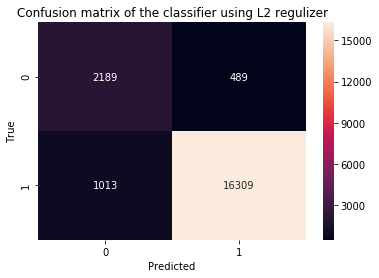

In [403]:
#Classification Report
print("Classification Report using L2 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l2)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l2)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier using L2 regulizer')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## PERTUBATION

In [404]:
#Generating Noise 
e=np.random.uniform(0,0.01)

In [405]:
X_train_d=X_train

X_train_d.data+=e

In [406]:
final_model_l2_d = LogisticRegression(penalty='l2',C=final_l2,class_weight='balanced')

final_model_l2_d.fit(X_train_d, train_label)

LogisticRegression(C=12.182493960703473, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [407]:
#Storing Weights

#Weight Vector before Adding noise 
w_l2=model_l2.coef_

#Weight Vector after Adding Noise
w_l2_d=final_model_l2_d.coef_

#Adding Small value to weights to avoid divide by Zero issue
w_l2_d=w_l2_d+10**-6
w_l2=w_l2+10**-6

In [408]:
#Calculating the change in values from w to w dash weights.
percentage_change_vector=(np.abs((w_l2-w_l2_d)/w_l2))*100


In [409]:
print(percentage_change_vector.max())
print(percentage_change_vector.mean())
print(percentage_change_vector.min())

187972.1796483544
88.54227327860717
0.0023256230726898027


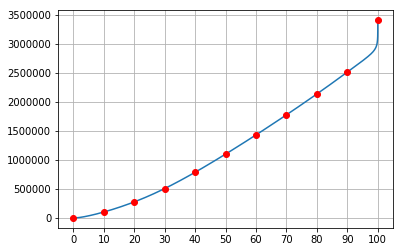

In [410]:
#code reference https://www.kaggle.com/souravdas4/amazon-food-reviews-using-logisticregression

#Ploting the cummulative percentile plot to find the threshold value 
from matplotlib import mlab

d = np.sort(percentage_change_vector).cumsum()
p = np.array(range(0,101,10))
perc = mlab.prctile(d, p=p)
plt.plot(d)

# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.grid()
plt.show()
  

### DECISION MAKING

WE OBSERVE THAT THERE IS A STEEP SLOPE AT 99 PERCENTILE HENCE 99 PERCENTILE SHOULD BE CHECKED

In [411]:
perc=np.linspace(99.1,100,10)

for i in perc:
    print("{} percentile - {}".format(i,np.percentile(percentage_change_vector,i)))
  

99.1 percentile - 224.5057171554568
99.19999999999999 percentile - 245.17631729998536
99.3 percentile - 271.9541859132696
99.39999999999999 percentile - 306.3846899737164
99.5 percentile - 363.35045462515666
99.6 percentile - 443.91738513929465
99.7 percentile - 587.8413644912664
99.8 percentile - 863.428779344874
99.9 percentile - 1524.511137738989
100.0 percentile - 187972.1796483544


WE SEE THAT THERE IS A SUDDEN JUMP AFTER 99.8 PERCENTILE THUS IT IS TAKEN TO BE THE THRESHOLD

In [412]:
features=np.where(percentage_change_vector>np.percentile(percentage_change_vector,99.8))[1]

### FEATURES CORRESPOIND TO THRESHOLD VALUE GREATER THAN 99.8

In [413]:
names_reviews=count_vect.get_feature_names()
names_summary=count_vect_sum.get_feature_names()
for i in features:
    if(i>29133):
        print(names_summary[29134-i],end=" ")
    else:
        print(names_reviews[i],end=" ")
print('\n--------------------------------------------')
print("Total Number of features :",len(features))  

academi alternativw bellyflop bloated chopstick coast commit comt contiu dachsund diego dog electrolyt electron evap expertis froze furious gfcg give gooooood grear ham hous husband injest itll jeez kyiv leonardi let marshal nilla novic nutragrain oatam panni picki pictur potenti producto progam refut seventh sweeet tango taster theater tikka uneconom unhygen warhamm wingal zigelhof tastier smoklehous skyrocket shark roger relationship proflow poker occas multigener manjar luwak lemonad justifi japan fork forev flash exercis creameri boss arteri aficionado 
--------------------------------------------
Total Number of features : 77


### TOP 20 MOST IMPORTANT FEATURES



In [414]:
#Source : https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:20]
    topn_class2 = coefs[:-(21):-1]

    print("Top 20 negative features\n")
    for i in topn_class1:
        print(i)

    print("\n************************\n")
    print("Top 20 positive features\n")
    for i in topn_class2:
        print(i)
    
most_informative_feature_for_binary_classification(count_vect,final_model_l1)

Top 20 negative features

(-11.403853503714004, 'matic')
(-10.854875077487858, 'hime')
(-10.06979040773634, 'beautifuli')
(-8.791190002554387, 'trifl')
(-8.554356634693988, 'maunfactur')
(-8.071086704829543, 'caf')
(-8.043249657092034, 'worst')
(-7.799019820871999, 'simular')
(-7.542749347533636, 'thamk')
(-7.266352846912987, 'consequ')
(-6.892592223076551, 'storg')
(-6.71647633618289, 'morgan')
(-6.410257898725083, 'scam')
(-6.386171695351592, 'trusti')
(-6.20873010128983, 'multigrain')
(-6.180880319932322, 'fallen')
(-6.115764453851991, 'yup')
(-5.851744053065956, 'clasico')
(-5.746592894553317, 'mattress')
(-5.611387008519432, 'whatchamacallit')

************************

Top 20 positive features

(8.392973029152955, 'solv')
(5.560129173090449, 'hook')
(5.493386574309062, 'uniqu')
(5.346929892756209, 'relat')
(5.176630953501214, 'ketchup')
(4.857695265037739, 'skeptic')
(4.739788458684078, 'accur')
(4.614457226677176, 'quiet')
(4.5942443910052555, 'amaz')
(4.314121013202329, 'addict

### TF-IDF for Summary Text

In [415]:
if os.path.isfile('train.sqlite'):
    conn = sqlite3.connect('train.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [416]:
#TF-IDF on training Summary dataset
count_vect_tf_idf_sum = TfidfVectorizer() #in scikit-learn
final_counts_sum = count_vect_tf_idf_sum.fit_transform(final['CleanedSummaryText'].values)
X_train_sum=final_counts_sum
X_train_sum=normalize(X_train_sum, axis=1, norm='max')
print("the type of count vectorizer ",type(X_train_sum))
print("the shape of out text BOW vectorizer ",X_train_sum.get_shape())
print("the number of unique words ", X_train_sum.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 9357)
the number of unique words  9357


In [417]:
if os.path.isfile('cross_validation.sqlite'):
    conn = sqlite3.connect('cross_validation.sqlite')
    final_cross_validation = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [418]:
#TF_IDF on CV Summary dataset
final_counts_cross_validation_sum = count_vect_tf_idf_sum.transform(final_cross_validation['CleanedSummaryText'].values)
X_cv_sum=final_counts_cross_validation_sum
X_cv_sum=normalize(X_cv_sum, axis=1, norm='max')
print("the type of count vectorizer ",type(X_cv_sum))
print("the shape of out text BOW vectorizer ",X_cv_sum.get_shape())
print("the number of unique words ", X_cv_sum.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 9357)
the number of unique words  9357


In [419]:
if os.path.isfile('test.sqlite'):
    conn = sqlite3.connect('test.sqlite')
    test = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [420]:
#TF-IDF on Test Summary dataset
test_count_sum = count_vect_tf_idf_sum.transform(test['CleanedSummaryText'].values)
X_test_sum=test_count_sum
X_test_sum=normalize(X_test_sum, axis=1, norm='max')
print("the type of count vectorizer ",type(X_test_sum))
print("the shape of out text BOW vectorizer ",X_test_sum.get_shape())
print("the number of unique words ", X_test_sum.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 9357)
the number of unique words  9357


### TF-IDF for Review Text

In [421]:
if os.path.isfile('train.sqlite'):
    conn = sqlite3.connect('train.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [422]:
#TF-IDF on training dataset
count_vect_tf_idf = TfidfVectorizer() #in scikit-learn
final_counts = count_vect_tf_idf.fit_transform(final['CleanedText'].values)
X_train=[]
X_train=final_counts
X_train=normalize(X_train, axis=1, norm='max')
train_label=final['Score'].values
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
X_train=hstack((X_train, X_train_sum))
X_train =csr_matrix(X_train)
print("the type of count vectorizer ",type(X_train))
print("the shape of out text BOW vectorizer ",X_train.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 29134)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 38491)


In [423]:
if os.path.isfile('cross_validation.sqlite'):
    conn = sqlite3.connect('cross_validation.sqlite')
    final_cross_validation = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [424]:
#TF_IDF on CV dataset
final_counts_cross_validation = count_vect_tf_idf.transform(final_cross_validation['CleanedText'].values)
X_cv=[]
X_cv=final_counts_cross_validation
X_cv=normalize(X_cv, axis=1, norm='max')
cv_label=final_cross_validation['Score'].values
print("the type of count vectorizer ",type(final_counts_cross_validation))
print("the shape of out text BOW vectorizer ",final_counts_cross_validation.get_shape())
X_cv=hstack((X_cv, X_cv_sum))
X_cv =csr_matrix(X_cv)
print("the type of count vectorizer ",type(X_cv))
print("the shape of out text BOW vectorizer ",X_cv.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 29134)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 38491)


In [425]:
if os.path.isfile('test.sqlite'):
    conn = sqlite3.connect('test.sqlite')
    test = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [426]:
#TF-IDF on Test dataset
test_count = count_vect_tf_idf.transform(test['CleanedText'].values)
X_test=[]
X_test=test_count
X_test=normalize(X_test, axis=1, norm='max')
test_label=test['Score'].values
print("the type of count vectorizer ",type(test_count))
print("the shape of out text BOW vectorizer ",test_count.get_shape())
X_test=hstack((X_test, X_test_sum))
X_test =csr_matrix(X_test)
print("the type of count vectorizer ",type(X_test))
print("the shape of out text BOW vectorizer ",X_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 29134)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 38491)


## Applying Logistic Classifier on TF-IDF

In [427]:
l=[10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

#Store Auc value for  train 
roc_val_cv_l1 = np.empty(len(l))

roc_val_train_l1 = np.empty(len(l))

#Store Auc value for  train 
roc_val_cv_l2 = np.empty(len(l))

roc_val_train_l2 = np.empty(len(l))


for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for Train data
    y_pred_train_l1 = []
    y_pred_proba_train_l1=[]
    #Store the predicted class labels for Train data
    y_pred_train_l2 = []
    y_pred_proba_train_l2=[]
    
    #Fit the model
    model_l1.fit(X_train, train_label)
    #Fit the model
    model_l2.fit(X_train, train_label)
    
    #Predict the Class label in Train data
    y_pred_train_l1=model_l1.predict(X_train)
    #Predict the Class label in Train data
    y_pred_train_l2=model_l2.predict(X_train)
    
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l1 = model_l1.predict_proba(X_train)[:,1]

    roc_val_train_l1[i] = roc_auc_score(train_label,y_pred_proba_train_l1)
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l2 = model_l2.predict_proba(X_train)[:,1]

    roc_val_train_l2[i] = roc_auc_score(train_label,y_pred_proba_train_l2)

In [428]:
#Performing Hyper parameter tuning for finding the best Lambda using simple cross validation.

for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for CV
    y_pred_cv_l1 = []
    y_pred_proba_cv_l1=[]
    y_pred_cv_l2 = []
    y_pred_proba_cv_l2=[]
    
    #Fit the model
    model_l1.fit(X_train, train_label)
    model_l2.fit(X_train, train_label)
    
    #Predict the Class label in CV data
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l1.predict(X_cv[d:d+2000]))
        
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l2.predict(X_cv[d:d+2000]))
        
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l1 = model_l1.predict_proba(X_cv)[:,1]
    
    roc_val_cv_l1[i] = roc_auc_score(cv_label,y_pred_proba_cv_l1)
    
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l2 = model_l2.predict_proba(X_cv)[:,1]
    
    roc_val_cv_l2[i] = roc_auc_score(cv_label,y_pred_proba_cv_l2)

In [429]:
l1_log=[np.log(i) for i in l]

l2_log=[np.log(i) for i in l]

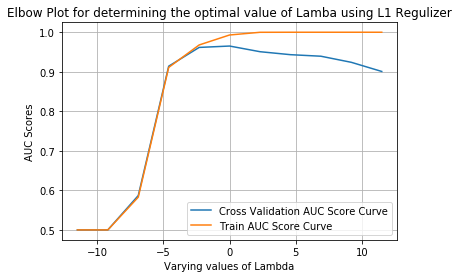

In [430]:
#Elbow Plot for determining the optimal value of Lambda using L1 regulizer
plt.title('Elbow Plot for determining the optimal value of Lamba using L1 Regulizer')
plt.plot(l1_log, roc_val_cv_l1, label='Cross Validation AUC Score Curve')
plt.plot(l1_log, roc_val_train_l1, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

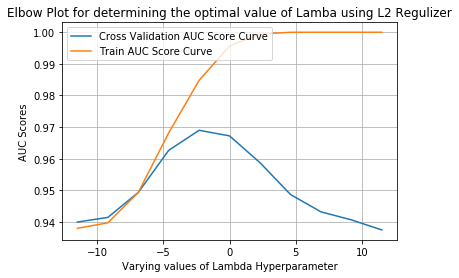

In [431]:
#Elbow Plot for determining the optimal value of Lambda using L2 Regulizer
plt.title('Elbow Plot for determining the optimal value of Lamba using L2 Regulizer')
plt.plot(l2_log, roc_val_cv_l2, label='Cross Validation AUC Score Curve')
plt.plot(l2_log, roc_val_train_l2, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda Hyperparameter')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

### Fitting the Test Data using optimal Lambda and applying Logistic Regression Classifier

In [432]:
final_l1=np.exp(.1)
final_l2=np.exp(2.5)

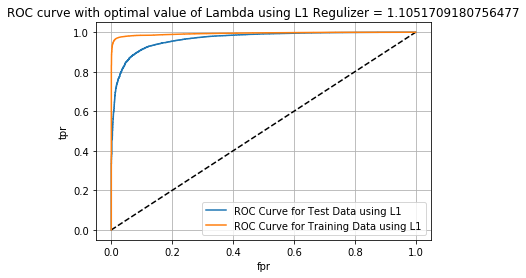

 AUC value for Test Data for Optimal Lambda using L1 Regulizer is 0.9667498169151043
 AUC value for Training Data for Optimal Lambda using L1 Regulizer 0.9937345722038083


In [433]:
# Applying Optimal Value of Lambda obtained from simple cross validation on test data for L1 and L2 regulizer

final_model_l1 = LogisticRegression(penalty='l1',C=final_l1,class_weight='balanced')
final_model_l2 = LogisticRegression(penalty='l2',C=final_l2,class_weight='balanced')

#Store the predicted class labels and prob scores for Test data
y_pred_test_l1 = []
y_pred_proba_test_l1=[]
y_pred_train_l1 = []
y_pred_proba_train_l1=[]
y_pred_test_l2 = []
y_pred_proba_test_l2=[]
y_pred_train_l2 = []
y_pred_proba_train_l2=[]
    
#Fit the model
final_model_l1.fit(X_train, train_label)
final_model_l2.fit(X_train, train_label)
    
#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l1.extend(final_model_l1.predict(X_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l1 = final_model_l1.predict_proba(X_test)[:,1]

#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l2.extend(final_model_l2.predict(X_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l2 = final_model_l2.predict_proba(X_test)[:,1]

fpr1_l1, tpr1_l1, thresholds = roc_curve(test_label,y_pred_proba_test_l1)
roc_val_test_l1 = roc_auc_score(test_label,y_pred_proba_test_l1)

fpr1_l2, tpr1_l2, thresholds = roc_curve(test_label,y_pred_proba_test_l2)
roc_val_test_l2 = roc_auc_score(test_label,y_pred_proba_test_l2)


#Predict the Class label in Train data
y_pred_train_l1=final_model_l1.predict(X_train)
y_pred_proba_train_l1=final_model_l1.predict_proba(X_train)[:,1]

#Predict the Class label in Train data
y_pred_train_l2=final_model_l2.predict(X_train)
y_pred_proba_train_l2=final_model_l2.predict_proba(X_train)[:,1]

fpr2_l1, tpr2_l1, thresholds = roc_curve(train_label,y_pred_proba_train_l1)
roc_val_train_l1 = roc_auc_score(train_label,y_pred_proba_train_l1)

fpr2_l2, tpr2_l2, thresholds = roc_curve(train_label,y_pred_proba_train_l2)
roc_val_train_l2 = roc_auc_score(train_label,y_pred_proba_train_l2)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l1,tpr1_l1, label='ROC Curve for Test Data using L1')
plt.plot(fpr2_l1,tpr2_l1, label='ROC Curve for Training Data using L1')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal value of Lambda using L1 Regulizer = {}' . format(final_l1))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L1 Regulizer is {}".format(roc_val_test_l1))
print (" AUC value for Training Data for Optimal Lambda using L1 Regulizer {}".format(roc_val_train_l1))

Classification Report using L1 Regulizer: 
             precision    recall  f1-score   support

          0       0.67      0.87      0.75      2678
          1       0.98      0.93      0.96     17322

avg / total       0.94      0.92      0.93     20000

----------------------------


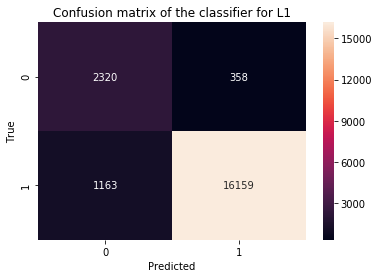

In [434]:
#Classification Report
#import classification_report
from sklearn.metrics import classification_report
print("Classification Report using L1 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l1)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
from sklearn.metrics import confusion_matrix
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l1)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier for L1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

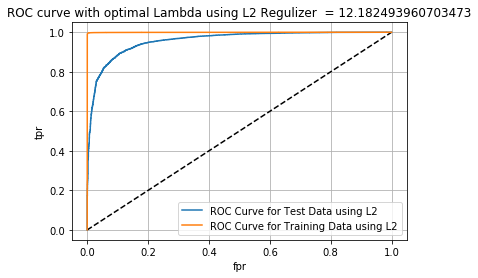

 AUC value for Test Data for Optimal Lambda using L2 Regulizer  is 0.9579145964255309
 AUC value for Training Data for Optimal Lambda using L2 Regulizer is 0.9995499117995488


In [435]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l2,tpr1_l2, label='ROC Curve for Test Data using L2')
plt.plot(fpr2_l2,tpr2_l2, label='ROC Curve for Training Data using L2')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal Lambda using L2 Regulizer  = {}' . format(final_l2))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L2 Regulizer  is {}".format(roc_val_test_l2))
print (" AUC value for Training Data for Optimal Lambda using L2 Regulizer is {}".format(roc_val_train_l2))

Classification Report using L2 Regulizer: 
             precision    recall  f1-score   support

          0       0.70      0.81      0.75      2678
          1       0.97      0.95      0.96     17322

avg / total       0.93      0.93      0.93     20000

----------------------------


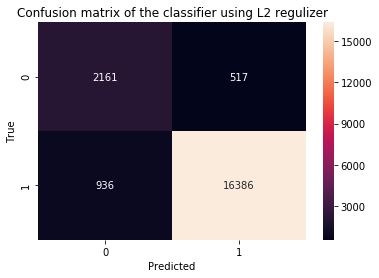

In [436]:
#Classification Report
print("Classification Report using L2 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l2)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l2)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier using L2 regulizer')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [437]:
#Source : https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:20]
    topn_class2 = coefs[:-(21):-1]

    print("Top 20 negative features\n")
    for i in topn_class1:
        print(i)

    print("\n************************\n")
    print("Top 20 positive features\n")
    for i in topn_class2:
        print(i)
    
most_informative_feature_for_binary_classification(count_vect_tf_idf,final_model_l1)

Top 20 negative features

(-8.44650512603405, 'hime')
(-7.573681388665202, 'hapkido')
(-7.240270035163794, 'beautifuli')
(-7.148917922038894, 'maunfactur')
(-6.869362291143, 'worst')
(-6.864592243591652, 'matic')
(-6.643138650125707, 'fyou')
(-6.556376913191701, 'caf')
(-6.316522576207729, 'thougth')
(-6.251167738692059, 'consequ')
(-6.154910659115923, 'morgan')
(-5.725331769182594, 'trifl')
(-5.7161577687559015, 'mattress')
(-5.703685586398378, 'tradeoff')
(-5.628083909637032, 'simular')
(-5.489280491665147, 'fallen')
(-5.161002859308106, 'malnourish')
(-5.108193515693052, 'thamk')
(-4.941521671685161, 'disappoint')
(-4.933672916884615, 'texarkana')

************************

Top 20 positive features

(6.969495657602891, 'solv')
(6.145567854846393, 'great')
(6.012462843748969, 'perfect')
(5.558606725940974, 'hook')
(5.338274048623147, 'delici')
(5.215377110265046, 'excel')
(5.151901742881975, 'amaz')
(5.125276687683966, 'uniqu')
(4.926125242665796, 'best')
(4.695637654095079, 'addict'

## Featurization using TF-IDF-Word2Vec

In [438]:
if os.path.isfile('train.sqlite'):
    conn = sqlite3.connect('train.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [439]:
# Train your own Word2Vec model using your own text corpus from training data 
i=0
list_of_sent_train=[]
for sent in final['CleanedText'].values:
    list_of_sent_train.append(sent.split())

In [440]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=100)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:5])

number of words that occured minimum 5 times  9959
sample words  ['chanc', 'extra', 'scarf', 'elong', 'hunch']


In [441]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(count_vect_tf_idf.get_feature_names(), list(count_vect_tf_idf.idf_)))

In [442]:
# TF-IDF weighted Word2Vec
tfidf_feat = count_vect_tf_idf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in (list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train=normalize(tfidf_sent_vectors_train, axis=1, norm='max')

In [443]:
if os.path.isfile('cross_validation.sqlite'):
    conn = sqlite3.connect('cross_validation.sqlite')
    final_cross_validation = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [444]:
i=0
list_of_sent_cv=[]
for sent in final_cross_validation['CleanedText'].values:
    list_of_sent_cv.append(sent.split())

In [445]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in (list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
from sklearn.preprocessing import normalize
tfidf_sent_vectors_cv=normalize(tfidf_sent_vectors_cv, axis=1, norm='max')

In [446]:
if os.path.isfile('test.sqlite'):
    conn = sqlite3.connect('test.sqlite')
    test = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [447]:
i=0
list_of_sent_test=[]
for sent in test['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [448]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in (list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test=normalize(tfidf_sent_vectors_test, axis=1, norm='max')

## Applying Logistic Classifier on TF-IDF-Word2Vec

In [449]:
#import LogisticRegression Classifier

l=[10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

#Store Auc value for  train 
roc_val_cv_l1 = np.empty(len(l))

roc_val_train_l1 = np.empty(len(l))

#Store Auc value for  train 
roc_val_cv_l2 = np.empty(len(l))

roc_val_train_l2 = np.empty(len(l))


for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for Train data
    y_pred_train_l1 = []
    y_pred_proba_train_l1=[]
    #Store the predicted class labels for Train data
    y_pred_train_l2 = []
    y_pred_proba_train_l2=[]
    
    #Fit the model
    model_l1.fit(tfidf_sent_vectors_train, train_label)
    #Fit the model
    model_l2.fit(tfidf_sent_vectors_train, train_label)
    
    #Predict the Class label in Train data
    y_pred_train_l1=model_l1.predict(tfidf_sent_vectors_train)
    #Predict the Class label in Train data
    y_pred_train_l2=model_l2.predict(tfidf_sent_vectors_train)
    
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l1 = model_l1.predict_proba(tfidf_sent_vectors_train)[:,1]

    roc_val_train_l1[i] = roc_auc_score(train_label,y_pred_proba_train_l1)
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l2 = model_l2.predict_proba(tfidf_sent_vectors_train)[:,1]

    roc_val_train_l2[i] = roc_auc_score(train_label,y_pred_proba_train_l2)

In [450]:
#Performing Hyper parameter tuning for finding the best Lambda using simple cross validation.

for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for CV
    y_pred_cv_l1 = []
    y_pred_proba_cv_l1=[]
    y_pred_cv_l2 = []
    y_pred_proba_cv_l2=[]
    
    #Fit the model
    model_l1.fit(tfidf_sent_vectors_train, train_label)
    model_l2.fit(tfidf_sent_vectors_train, train_label)
    
    #Predict the Class label in CV data
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l1.predict(tfidf_sent_vectors_cv[d:d+2000]))
        
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l2.predict(tfidf_sent_vectors_cv[d:d+2000]))
        
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l1 = model_l1.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    roc_val_cv_l1[i] = roc_auc_score(cv_label,y_pred_proba_cv_l1)
    
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l2 = model_l2.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    roc_val_cv_l2[i] = roc_auc_score(cv_label,y_pred_proba_cv_l2)

In [451]:
l1_log=[np.log(i) for i in l]

l2_log=[np.log(i) for i in l]

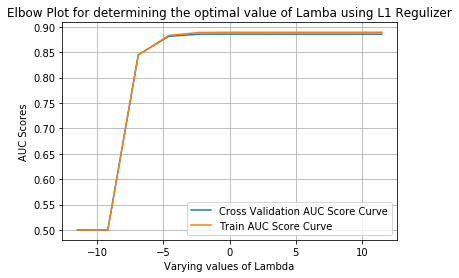

In [452]:
#Elbow Plot for determining the optimal value of Lambda using L1 regulizer
plt.title('Elbow Plot for determining the optimal value of Lamba using L1 Regulizer')
plt.plot(l1_log, roc_val_cv_l1, label='Cross Validation AUC Score Curve')
plt.plot(l1_log, roc_val_train_l1, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

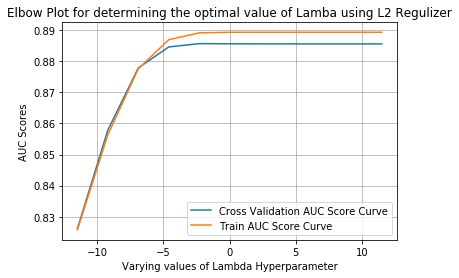

In [453]:
#Elbow Plot for determining the optimal value of Alpha
plt.title('Elbow Plot for determining the optimal value of Lamba using L2 Regulizer')
plt.plot(l2_log, roc_val_cv_l2, label='Cross Validation AUC Score Curve')
plt.plot(l2_log, roc_val_train_l2, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda Hyperparameter')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

### Fitting the Test Data using optimal lambda and applying Logistic Regression Classifier

In [454]:
final_l1=np.exp(-5.5)
final_l2=np.exp(-5.5)

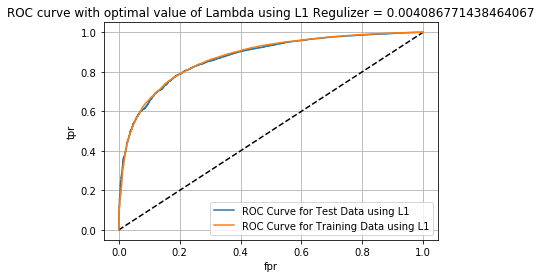

 AUC value for Test Data for Optimal Lambda using L1 Regulizer is 0.8729727007119638
 AUC value for Training Data for Optimal Lambda using L1 Regulizer 0.8752010518384385


In [455]:
# Applying Optimal Value of Lambda obtained from simple cross validation on test data for L1 and L2 regulizer

final_model_l1 = LogisticRegression(penalty='l1',C=final_l1,class_weight='balanced')
final_model_l2 = LogisticRegression(penalty='l2',C=final_l2,class_weight='balanced')

#Store the predicted class labels and prob scores for Test data
y_pred_test_l1 = []
y_pred_proba_test_l1=[]
y_pred_train_l1 = []
y_pred_proba_train_l1=[]
y_pred_test_l2 = []
y_pred_proba_test_l2=[]
y_pred_train_l2 = []
y_pred_proba_train_l2=[]
    
#Fit the model
final_model_l1.fit(tfidf_sent_vectors_train, train_label)
final_model_l2.fit(tfidf_sent_vectors_train, train_label)
    
#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l1.extend(final_model_l1.predict(tfidf_sent_vectors_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l1 = final_model_l1.predict_proba(tfidf_sent_vectors_test)[:,1]

#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l2.extend(final_model_l2.predict(tfidf_sent_vectors_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l2 = final_model_l2.predict_proba(tfidf_sent_vectors_test)[:,1]

fpr1_l1, tpr1_l1, thresholds = roc_curve(test_label,y_pred_proba_test_l1)
roc_val_test_l1 = roc_auc_score(test_label,y_pred_proba_test_l1)

fpr1_l2, tpr1_l2, thresholds = roc_curve(test_label,y_pred_proba_test_l2)
roc_val_test_l2 = roc_auc_score(test_label,y_pred_proba_test_l2)


#Predict the Class label in Train data
y_pred_train_l1=final_model_l1.predict(tfidf_sent_vectors_train)
y_pred_proba_train_l1=final_model_l1.predict_proba(tfidf_sent_vectors_train)[:,1]

#Predict the Class label in Train data
y_pred_train_l2=final_model_l2.predict(tfidf_sent_vectors_train)
y_pred_proba_train_l2=final_model_l2.predict_proba(tfidf_sent_vectors_train)[:,1]

fpr2_l1, tpr2_l1, thresholds = roc_curve(train_label,y_pred_proba_train_l1)
roc_val_train_l1 = roc_auc_score(train_label,y_pred_proba_train_l1)

fpr2_l2, tpr2_l2, thresholds = roc_curve(train_label,y_pred_proba_train_l2)
roc_val_train_l2 = roc_auc_score(train_label,y_pred_proba_train_l2)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l1,tpr1_l1, label='ROC Curve for Test Data using L1')
plt.plot(fpr2_l1,tpr2_l1, label='ROC Curve for Training Data using L1')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal value of Lambda using L1 Regulizer = {}' . format(final_l1))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L1 Regulizer is {}".format(roc_val_test_l1))
print (" AUC value for Training Data for Optimal Lambda using L1 Regulizer {}".format(roc_val_train_l1))

Classification Report using L1 Regulizer: 
             precision    recall  f1-score   support

          0       0.35      0.82      0.49      2678
          1       0.97      0.77      0.85     17322

avg / total       0.88      0.77      0.81     20000

----------------------------


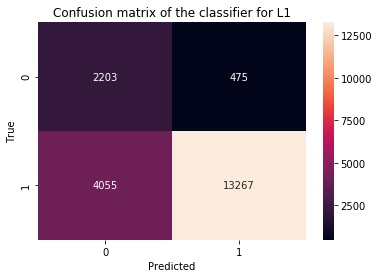

In [456]:
#Classification Report
#import classification_report
from sklearn.metrics import classification_report
print("Classification Report using L1 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l1)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
from sklearn.metrics import confusion_matrix
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l1)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier for L1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

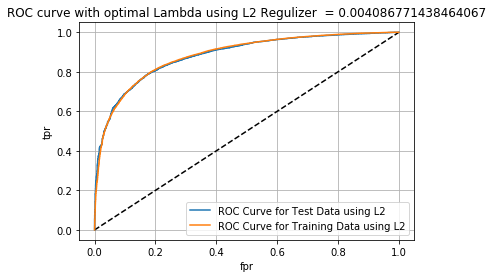

 AUC value for Test Data for Optimal Lambda using L2 Regulizer  is 0.8836113925756649
 AUC value for Training Data for Optimal Lambda using L2 Regulizer is 0.8845005674113112


In [457]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l2,tpr1_l2, label='ROC Curve for Test Data using L2')
plt.plot(fpr2_l2,tpr2_l2, label='ROC Curve for Training Data using L2')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal Lambda using L2 Regulizer  = {}' . format(final_l2))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L2 Regulizer  is {}".format(roc_val_test_l2))
print (" AUC value for Training Data for Optimal Lambda using L2 Regulizer is {}".format(roc_val_train_l2))

Classification Report using L2 Regulizer: 
             precision    recall  f1-score   support

          0       0.37      0.83      0.51      2678
          1       0.97      0.78      0.87     17322

avg / total       0.89      0.79      0.82     20000

----------------------------


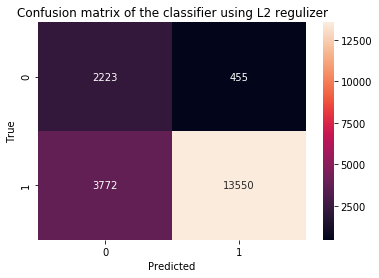

In [458]:
#Classification Report
print("Classification Report using L2 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l2)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l2)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier using L2 regulizer')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### TOP 20 MOST IMPORTANT FEATURES



In [459]:
#Source : https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = w2v_model.wv.vocab
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:20]
    topn_class2 = coefs[:-(21):-1]

    print("Top 20 negative features\n")
    for i in topn_class1:
        print(i)

    print("\n************************\n")
    print("Top 20 positive features\n")
    for i in topn_class2:
        print(i)
    
most_informative_feature_for_binary_classification(w2v_model,final_model_l1)

Top 20 negative features

(-0.7351461343158137, 'casbah')
(-0.7273651095965924, 'mud')
(-0.6871397973314554, 'hong')
(-0.6639340104283586, 'conserv')
(-0.42073561541415055, 'snappl')
(-0.3784146305623709, 'marriag')
(-0.37680144063275955, 'acai')
(-0.2882884331436979, 'depress')
(-0.25603930017437304, 'buttercream')
(-0.24719635398076287, 'gel')
(-0.2375293225634183, 'besid')
(-0.20891461909229742, 'inform')
(-0.19342607067972487, 'bouquet')
(-0.19213466084879235, 'chanc')
(-0.1809776739850665, 'acquir')
(-0.1646460485192448, 'escap')
(-0.16286656157023977, 'dougla')
(-0.16206282896456367, 'flood')
(-0.14171987370546923, 'cylind')
(-0.1323244558049272, 'caviar')

************************

Top 20 positive features

(1.0949078011538362, 'electr')
(0.8790697107478184, 'weigh')
(0.868416758404338, 'parchment')
(0.7575028899736154, 'snackmast')
(0.7438899803888883, 'pallet')
(0.7053109812841648, 'privileg')
(0.659837830809745, 'skittl')
(0.4561625111008019, 'discard')
(0.44608880837602166, 

## Featurization using AVG-Word2Vec

In [460]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
sent_vectors_train=normalize(sent_vectors_train, axis=1, norm='max')

60000
100


In [461]:
# average Word2Vec for CV data
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (list_of_sent_cv): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
sent_vectors_cv=normalize(sent_vectors_cv, axis=1, norm='max')

20000
100


In [462]:
# average Word2Vec Test train data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
sent_vectors_test=normalize(sent_vectors_test, axis=1, norm='max')

20000
100


## Applying Logistic Regression Classifier on AVG-Word2Vec

In [463]:
l=[10**-5,10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4,10**5]

#Store Auc value for  train 
roc_val_cv_l1 = np.empty(len(l))

roc_val_train_l1 = np.empty(len(l))

#Store Auc value for  train 
roc_val_cv_l2 = np.empty(len(l))

roc_val_train_l2 = np.empty(len(l))


for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for Train data
    y_pred_train_l1 = []
    y_pred_proba_train_l1=[]
    #Store the predicted class labels for Train data
    y_pred_train_l2 = []
    y_pred_proba_train_l2=[]
    
    #Fit the model
    model_l1.fit(sent_vectors_train, train_label)
    #Fit the model
    model_l2.fit(sent_vectors_train, train_label)
    
    #Predict the Class label in Train data
    y_pred_train_l1=model_l1.predict(sent_vectors_train)
    #Predict the Class label in Train data
    y_pred_train_l2=model_l2.predict(sent_vectors_train)
    
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l1 = model_l1.predict_proba(sent_vectors_train)[:,1]

    roc_val_train_l1[i] = roc_auc_score(train_label,y_pred_proba_train_l1)
    
    #Compute the Prob Scores for ROC for Train
    y_pred_proba_train_l2 = model_l2.predict_proba(sent_vectors_train)[:,1]

    roc_val_train_l2[i] = roc_auc_score(train_label,y_pred_proba_train_l2)

In [464]:
#Performing Hyper parameter tuning for finding the best Lambda using simple cross validation.

for i,k in enumerate((l)):
    #Setup a Logistice Regression Classifier for L1 nd L2 Regulizer
    model_l1 = LogisticRegression(penalty='l1',C=k,class_weight='balanced')
    model_l2 = LogisticRegression(penalty='l2',C=k,class_weight='balanced')
    
    #Store the predicted class labels for CV
    y_pred_cv_l1 = []
    y_pred_proba_cv_l1=[]
    y_pred_cv_l2 = []
    y_pred_proba_cv_l2=[]
    
    #Fit the model
    model_l1.fit(sent_vectors_train, train_label)
    model_l2.fit(sent_vectors_train, train_label)
    
    #Predict the Class label in CV data
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l1.predict(sent_vectors_cv[d:d+2000]))
        
    for d in range(0, 20000, 2000):
        y_pred_cv_l1.extend(model_l2.predict(sent_vectors_cv[d:d+2000]))
        
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l1 = model_l1.predict_proba(sent_vectors_cv)[:,1]
    
    roc_val_cv_l1[i] = roc_auc_score(cv_label,y_pred_proba_cv_l1)
    
    #Compute the Prob Scores for ROC for CV
    y_pred_proba_cv_l2 = model_l2.predict_proba(sent_vectors_cv)[:,1]
    
    roc_val_cv_l2[i] = roc_auc_score(cv_label,y_pred_proba_cv_l2)

In [465]:
l1_log=[np.log(i) for i in l]

l2_log=[np.log(i) for i in l]

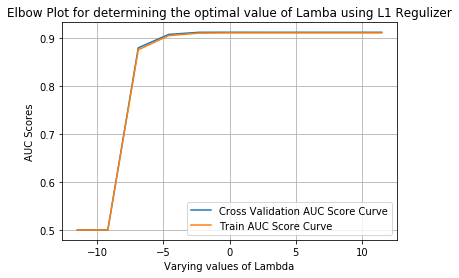

In [466]:
#Elbow Plot for determining the optimal value of Lambda using L1 regulizer
plt.title('Elbow Plot for determining the optimal value of Lamba using L1 Regulizer')
plt.plot(l1_log, roc_val_cv_l1, label='Cross Validation AUC Score Curve')
plt.plot(l1_log, roc_val_train_l1, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

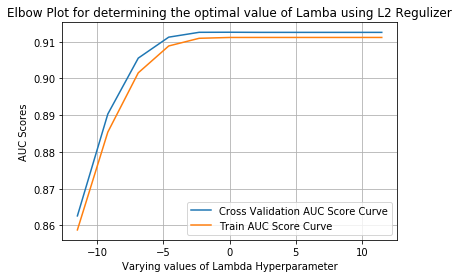

In [467]:
#Elbow Plot for determining the optimal value of Alpha
plt.title('Elbow Plot for determining the optimal value of Lamba using L2 Regulizer')
plt.plot(l2_log, roc_val_cv_l2, label='Cross Validation AUC Score Curve')
plt.plot(l2_log, roc_val_train_l2, label='Train AUC Score Curve')
plt.legend()
plt.xlabel('Varying values of Lambda Hyperparameter')
plt.ylabel('AUC Scores')
plt.grid()
plt.show()

### Fitting the Test Data using optimal lambda and applying Logistic Regression Classifier

In [479]:
final_l1=np.exp(-5.5)
final_l2=np.exp(-2.5)

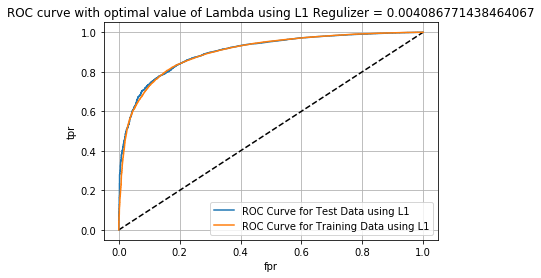

 AUC value for Test Data for Optimal Lambda using L1 Regulizer is 0.902025943343147
 AUC value for Training Data for Optimal Lambda using L1 Regulizer 0.89981945787827


In [480]:
# Applying Optimal Value of Lambda obtained from simple cross validation on test data for L1 and L2 regulizer

final_model_l1 = LogisticRegression(penalty='l1',C=final_l1,class_weight='balanced')
final_model_l2 = LogisticRegression(penalty='l2',C=final_l2,class_weight='balanced')

#Store the predicted class labels and prob scores for Test data
y_pred_test_l1 = []
y_pred_proba_test_l1=[]
y_pred_train_l1 = []
y_pred_proba_train_l1=[]
y_pred_test_l2 = []
y_pred_proba_test_l2=[]
y_pred_train_l2 = []
y_pred_proba_train_l2=[]
    
#Fit the model
final_model_l1.fit(sent_vectors_train, train_label)
final_model_l2.fit(sent_vectors_train, train_label)
    
#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l1.extend(final_model_l1.predict(sent_vectors_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l1 = final_model_l1.predict_proba(sent_vectors_test)[:,1]

#Predict the Class label in Test data
for d in range(0, 20000, 2000):
    y_pred_test_l2.extend(final_model_l2.predict(sent_vectors_test[d:d+2000]))
    
#Compute the Prob Scores for ROC for Test
y_pred_proba_test_l2 = final_model_l2.predict_proba(sent_vectors_test)[:,1]

fpr1_l1, tpr1_l1, thresholds = roc_curve(test_label,y_pred_proba_test_l1)
roc_val_test_l1 = roc_auc_score(test_label,y_pred_proba_test_l1)

fpr1_l2, tpr1_l2, thresholds = roc_curve(test_label,y_pred_proba_test_l2)
roc_val_test_l2 = roc_auc_score(test_label,y_pred_proba_test_l2)


#Predict the Class label in Train data
y_pred_train_l1=final_model_l1.predict(sent_vectors_train)
y_pred_proba_train_l1=final_model_l1.predict_proba(sent_vectors_train)[:,1]

#Predict the Class label in Train data
y_pred_train_l2=final_model_l2.predict(sent_vectors_train)
y_pred_proba_train_l2=final_model_l2.predict_proba(sent_vectors_train)[:,1]

fpr2_l1, tpr2_l1, thresholds = roc_curve(train_label,y_pred_proba_train_l1)
roc_val_train_l1 = roc_auc_score(train_label,y_pred_proba_train_l1)

fpr2_l2, tpr2_l2, thresholds = roc_curve(train_label,y_pred_proba_train_l2)
roc_val_train_l2 = roc_auc_score(train_label,y_pred_proba_train_l2)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l1,tpr1_l1, label='ROC Curve for Test Data using L1')
plt.plot(fpr2_l1,tpr2_l1, label='ROC Curve for Training Data using L1')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal value of Lambda using L1 Regulizer = {}' . format(final_l1))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L1 Regulizer is {}".format(roc_val_test_l1))
print (" AUC value for Training Data for Optimal Lambda using L1 Regulizer {}".format(roc_val_train_l1))

Classification Report using L1 Regulizer: 
             precision    recall  f1-score   support

          0       0.38      0.85      0.53      2678
          1       0.97      0.79      0.87     17322

avg / total       0.89      0.80      0.82     20000

----------------------------


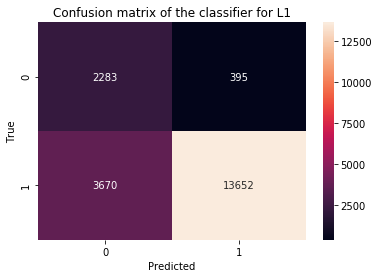

In [481]:
#Classification Report
#import classification_report
from sklearn.metrics import classification_report
print("Classification Report using L1 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l1)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
from sklearn.metrics import confusion_matrix
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l1)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier for L1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

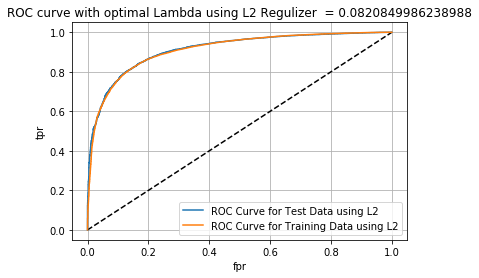

 AUC value for Test Data for Optimal Lambda using L2 Regulizer  is 0.9131158695219719
 AUC value for Training Data for Optimal Lambda using L2 Regulizer is 0.910859790217404


In [482]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr1_l2,tpr1_l2, label='ROC Curve for Test Data using L2')
plt.plot(fpr2_l2,tpr2_l2, label='ROC Curve for Training Data using L2')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid()
plt.title('ROC curve with optimal Lambda using L2 Regulizer  = {}' . format(final_l2))
plt.show()

print (" AUC value for Test Data for Optimal Lambda using L2 Regulizer  is {}".format(roc_val_test_l2))
print (" AUC value for Training Data for Optimal Lambda using L2 Regulizer is {}".format(roc_val_train_l2))

Classification Report using L2 Regulizer: 
             precision    recall  f1-score   support

          0       0.41      0.87      0.56      2678
          1       0.97      0.81      0.88     17322

avg / total       0.90      0.81      0.84     20000

----------------------------


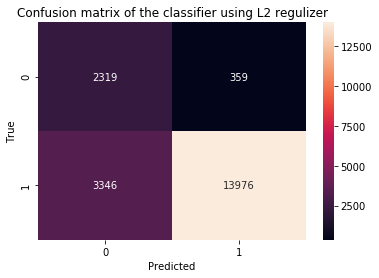

In [483]:
#Classification Report
print("Classification Report using L2 Regulizer: ")
print("{}".format(classification_report(test_label,y_pred_test_l2)))
print("----------------------------")

#Source : https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#Confusion matrix using Heat Map
labels = ['0', '1']
cm = confusion_matrix(test_label, y_pred_test_l2)
sns.heatmap(cm,annot=True,fmt='2.0f')
plt.title('Confusion matrix of the classifier using L2 regulizer')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### TOP 10 MOST IMPORTANT FEATURES



In [484]:
#Source : https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = w2v_model.wv.vocab
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:10]
    topn_class2 = coefs[:-(11):-1]

    print("Top 10 negative features\n")
    for i in topn_class1:
        print(i)

    print("\n************************\n")
    print("Top 10 positive features\n")
    for i in topn_class2:
        print(i)
    
most_informative_feature_for_binary_classification(w2v_model,final_model_l1)

Top 10 negative features

(-0.8463230998393908, 'casbah')
(-0.6859508321039676, 'mud')
(-0.6848743968625568, 'conserv')
(-0.6317305261639599, 'depress')
(-0.6303012754675461, 'hong')
(-0.4849010818887988, 'inform')
(-0.4683316770175819, 'marriag')
(-0.309259584627081, 'besid')
(-0.2976756940462396, 'buttercream')
(-0.2972050421754117, 'chanc')

************************

Top 10 positive features

(1.1497043543069676, 'parchment')
(1.0851784371266258, 'electr')
(0.9487335737771174, 'privileg')
(0.8871684769483129, 'pallet')
(0.8324548161638458, 'snackmast')
(0.8144887704336221, 'weigh')
(0.7111344222433292, 'skittl')
(0.5909466847984581, 'discard')
(0.4352802095824993, 'amout')
(0.4265084560441521, 'merchant')


In [485]:
#Source : http://zetcode.com/python/prettytable/

x = PrettyTable()

x.field_names = ["Vectorizer ", "Model", "Regulizer" ,"C", "AUC"]

x.add_row(["BOW", "Logistic-Regression","L1",1.10517091808,0.9671022116862358])
x.add_row(["BOW", "Logistic-Regression","L2",12.1824939607, 0.9581805685724827])
x.add_row(["TF-IDF", "Logistic-Regression","L1",1.10517091808, 0.9667498169151043])
x.add_row(["TF-IDF", "Logistic-Regression","L2",12.1824939607 , 0.9579145964255309])
x.add_row(["TF-IDF-W2V", "Logistic-Regression","L1",0.00408677143, 0.8729727007119638])
x.add_row(["TF-IDF-W2V", "Logistic-Regression","L2",0.00408677143, 0.8836113925756649])
x.add_row(["AVG-W2V", "Logistic-Regression","L1",0.00408677143, 0.9020247792569147])
x.add_row(["AVG-W2V", "Logistic-Regression","L2",0.08208499862, 0.9131158695219719])


print(x)

+-------------+---------------------+-----------+---------------+--------------------+
| Vectorizer  |        Model        | Regulizer |       C       |        AUC         |
+-------------+---------------------+-----------+---------------+--------------------+
|     BOW     | Logistic-Regression |     L1    | 1.10517091808 | 0.9671022116862358 |
|     BOW     | Logistic-Regression |     L2    | 12.1824939607 | 0.9581805685724827 |
|    TF-IDF   | Logistic-Regression |     L1    | 1.10517091808 | 0.9667498169151043 |
|    TF-IDF   | Logistic-Regression |     L2    | 12.1824939607 | 0.9579145964255309 |
|  TF-IDF-W2V | Logistic-Regression |     L1    | 0.00408677143 | 0.8729727007119638 |
|  TF-IDF-W2V | Logistic-Regression |     L2    | 0.00408677143 | 0.8836113925756649 |
|   AVG-W2V   | Logistic-Regression |     L1    | 0.00408677143 | 0.9020247792569147 |
|   AVG-W2V   | Logistic-Regression |     L2    | 0.08208499862 | 0.9131158695219719 |
+-------------+---------------------+------

Observations :


1. The optimal value of c varied between 0.004 to 12.1 for both L1 and L2 Regulizer.

2. The  Model Performance was found to be better using either BOW/TF-IDF than AvgW2V/TF-IDF-W2V as can been see from AUC values from above table and FN Values from the confusion matrix.

3. The threshold where there was a change in weight in case of BOW using l2 regulizer was found to be 99.8% when checking for multicolinearity and 77 features where found.